Расстояние между вторым и первым пиком 11999999.999999106
Расстояние между третьим и вторым пиком 11999999.999999091
Среднее межмодовое расстояние в МГц 12.0
FWHM в МГЦ для первого пика: 2
FWHM в МГЦ для второго пика: 2
FWHM в МГЦ для третьего пика: 2


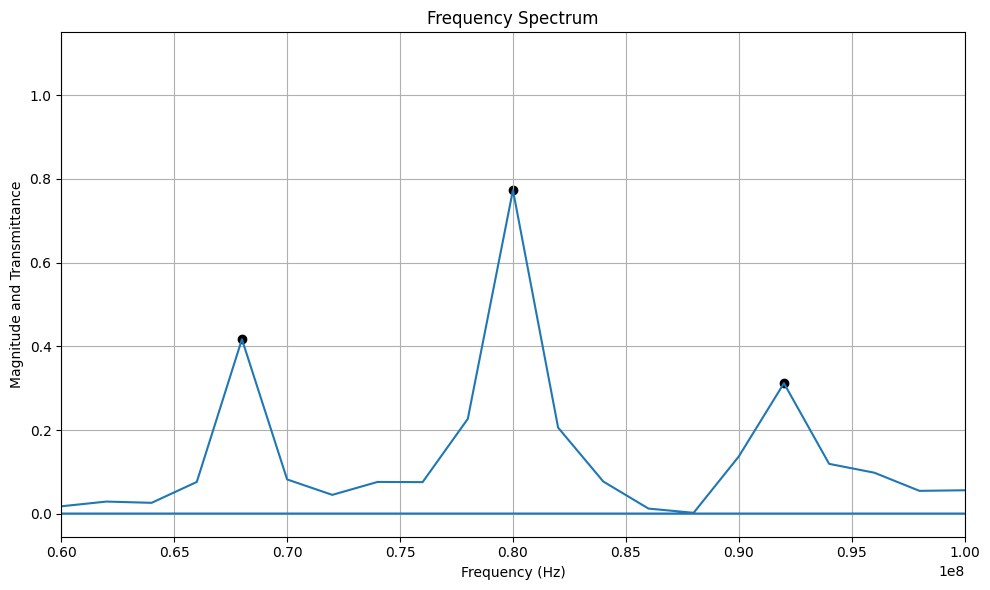

In [9]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
import pandas as pd
from scipy.signal import find_peaks

df = pd.read_csv('praktik6.csv')
spectr1 = np.array(df.iloc[:,0])
Spectr1 = np.array(df.iloc[:,1])

dt = spectr1[1] - spectr1[0]
fs = 1/dt
fft_signal = np.fft.fft(Spectr1)
freq = np.fft.fftfreq(len(Spectr1), d = dt)
#freq = freq[freq>0]
fft_signal_norm = fft_signal/max(fft_signal)

peaks, _ = find_peaks(abs(fft_signal_norm)) # Поиск индексов всех пиков
max_peaks = []
for i in range(len(peaks)): # Поиск пиков из нужного диапазона
    if (freq[peaks[i]] > 0.65e8) and (freq[peaks[i]] < 0.95e8): 
        max_peaks.append((freq[peaks[i]], abs(fft_signal_norm[peaks[i]])))
max_peaks.pop(1) #Удаление пика присущего шуму
#Поиск межмодового расстояния
print("Расстояние между вторым и первым пиком",max_peaks[1][0] - max_peaks[0][0])
print("Расстояние между третьим и вторым пиком",max_peaks[2][0] - max_peaks[1][0])
print("Среднее межмодовое расстояние в МГц", round(max_peaks[1][0] - max_peaks[0][0] + max_peaks[2][0] - max_peaks[1][0])/2 * 1e-6)

#Поиск FWHM
half_max_amplitude_first_peak = max_peaks[0][1]/2 # max_peaks[i][j], i - номер номер строки, j - номер столбца
half_max_amplitude_second_peak = max_peaks[1][1]/2
half_max_amplitude_third_peak = max_peaks[2][1]/2
#print(half_max_amplitude_third_peak)
crossings = []
crossings_2 = []
crossings_3 = []
for i in range(len(freq)):
    if (freq[i] > 0.65e8) and (freq[i] < 0.7e8):
        if (abs(fft_signal_norm[i]) - half_max_amplitude_first_peak) * (abs(fft_signal_norm[i-1]) - half_max_amplitude_first_peak) <= 0:
            crossings.append((freq[i], abs(fft_signal_norm[i])))
    if (freq[i] > 0.75e8) and (freq[i] < 0.85e8):
        if (abs(fft_signal_norm[i]) - half_max_amplitude_second_peak) * (abs(fft_signal_norm[i-1]) - half_max_amplitude_second_peak) <= 0:
            crossings_2.append((freq[i], abs(fft_signal_norm[i])))
    if (freq[i] > 0.86e8) and (freq[i] < 0.98e8):
        if (abs(fft_signal_norm[i]) - half_max_amplitude_third_peak) * (abs(fft_signal_norm[i-1]) - half_max_amplitude_third_peak) <= 0:
            crossings_3.append((freq[i], abs(fft_signal_norm[i])))
    if i == len(freq)-1:
        fwhm = abs(crossings[1][0] - crossings[0][0])
        print(f"FWHM в МГЦ для первого пика: {fwhm/1e6:.0f}")
    if i == len(freq)-1:
        fwhm = abs(crossings[1][0] - crossings[0][0])
        print(f"FWHM в МГЦ для второго пика: {fwhm/1e6:.0f}")
    if i == len(freq)-1:
        fwhm = abs(crossings[1][0] - crossings[0][0])
        print(f"FWHM в МГЦ для третьего пика: {fwhm/1e6:.0f}")

plt.figure(figsize = (10,6))
plt.plot(freq, np.abs(fft_signal_norm))
plt.scatter( [c[0] for c in max_peaks],[c[1] for c in max_peaks], color='k')  # точки пересечения
plt.xlim(60e6, 100e6)  # отображение только положительных частот
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude and Transmittance')
plt.title('Frequency Spectrum')
plt.grid(True)
plt.tight_layout()
plt.show()

FWHM в МГЦ: 39.500039499644515
FSR в МГЦ: 142.50014249871748


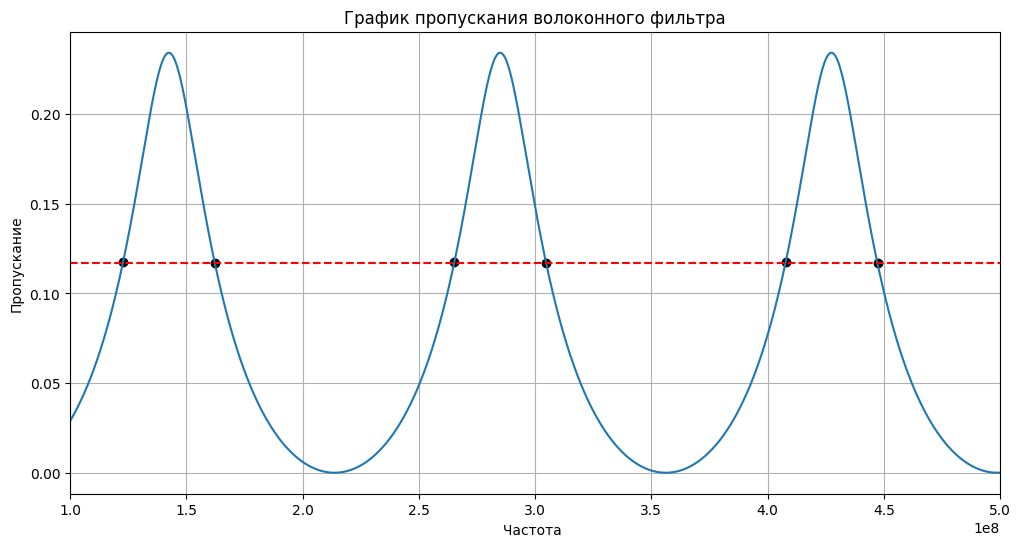

In [ ]:
import math
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
import pandas as pd
from scipy.signal import find_peaks
#%matplotlib qt 
df = pd.read_csv('praktik6.csv')
spectr1 = np.array(df.iloc[:,0])
Spectr1 = np.array(df.iloc[:,1])

dt = spectr1[1] - spectr1[0]
fs = 1/dt
fft_signal = np.fft.fft(Spectr1)
freq = np.fft.fftfreq(len(Spectr1), d = dt)
freq = freq[freq>0]
fft_signal_norm = fft_signal/max(fft_signal)
freq = np.linspace(1.0, 10e10, 1000000 )

k1 = 0.38
k2 = 0.38
n = 1.46
c = 3e8
S1 = np.sqrt(k1)
S2 = np.sqrt(k2)
C1 = np.sqrt(1-k1)
C2 = np.sqrt(1-k2)
α = 0.1
L = 1.442
γ = np.exp(-α * L)
T = n*L/c

def t_filter_first(w):
    z = np.exp(1j*w*2*np.pi*T)
    return  -(S1*S2*np.sqrt(γ*(z**(-1))/(1-C1*C2*γ*z**(-1))))
def T_filter_first(freq):
    result = []
    for w in freq:
        value = t_filter_first(w)
        result.append(value)
    return np.array(result)

T_values = np.abs(T_filter_first(freq))
T_values = T_values - np.min(T_values)
max_amplitude = np.max(T_values)
half_max_amplitude = max_amplitude / 2
# Поиск точек пересечения с половиной максимума
crossings = []
for i in range(len(T_values)):
    if (T_values[i] - half_max_amplitude) * (T_values[i-1] - half_max_amplitude) <= 0:
        crossings.append((freq[i], T_values[i]))
    if i == len(T_values)-1:
        fwhm = abs(crossings[3][0] - crossings[2][0])
        print(f"FWHM в МГЦ: {fwhm/1e6}")
    #else:
        #print("Не найдено двух пересечений с половиной максимума.")
        
# Поиск пиков
peaks, _ = find_peaks(T_values)
# Определение максимального пика
print('FSR в МГЦ:', (freq[peaks[1]]-freq[peaks[0]])/1e6)
#print('FWHM в МГЦ:', 39.500039499644515)
# Построим график зависимости модуля пропускания от частоты
plt.figure(figsize=(12, 6))
plt.plot(freq, T_values)
plt.axhline(half_max_amplitude, color='r', linestyle='--')  # линия половины максимума
plt.scatter([c[0] for c in crossings], [c[1] for c in crossings], color='k')  # точки пересечения
plt.xlim(100e6, 500e6)
plt.xlabel('Частота ')
plt.ylabel('Пропускание')
plt.title('График пропускания волоконного фильтра')
plt.grid(True)
plt.show()

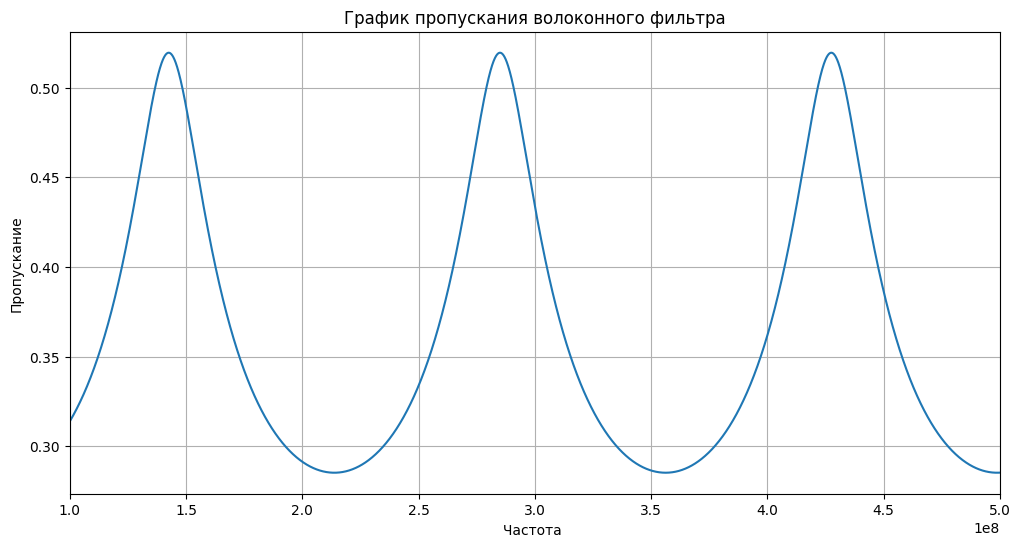

In [6]:
import math
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
import pandas as pd
from scipy.signal import find_peaks
#%matplotlib qt 
df = pd.read_csv('praktik6.csv')
spectr1 = np.array(df.iloc[:,0])
Spectr1 = np.array(df.iloc[:,1])

dt = spectr1[1] - spectr1[0]
freq = np.fft.fftfreq(len(Spectr1), d = dt)
freq = freq[freq>0]
freq = np.linspace(1.0, 10e10, 1000000 )

k1 = 0.38
k2 = 0.38
n = 1.46
c = 3e8
S1 = np.sqrt(k1)
S2 = np.sqrt(k2)
C1 = np.sqrt(1-k1)
C2 = np.sqrt(1-k2)
α = 0.1
L = 1.442
γ = np.exp(-α * L)
T = n*L/c

def t_filter_first(w):
    z = np.exp(1j*w*2*np.pi*T)
    return  -(S1*S2*np.sqrt(γ*(z**(-1))/(1-C1*C2*γ*z**(-1))))
def T_filter_first(freq):
    result = []
    for w in freq:
        value = t_filter_first(w)
        result.append(value)
    return np.array(result)
T_values = np.abs(T_filter_first(freq))
plt.figure(figsize=(12, 6))
plt.plot(freq, T_values)
plt.xlim(100e6, 500e6)
plt.xlabel('Частота ')
plt.ylabel('Пропускание')
plt.title('График пропускания волоконного фильтра')
plt.grid(True)
plt.show()

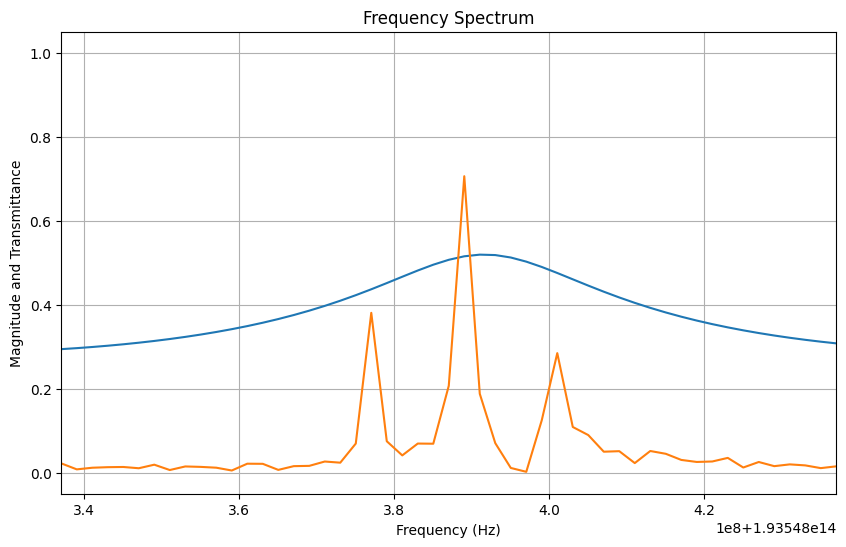

In [4]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
import pandas as pd
from scipy.signal import find_peaks
df = pd.read_csv('praktik6.csv')
spectr1 = np.array(df.iloc[:,0])
Spectr1 = np.array(df.iloc[:,1])
dt = spectr1[1] - spectr1[0]
fft_signal = np.fft.fft(Spectr1)
fft_signal = fft_signal[:len(fft_signal)//2-1]
freq = np.fft.fftfreq(len(Spectr1), d = dt)
freq = freq[freq>0]
fft_signal_norm = abs(fft_signal)/max(abs(fft_signal))
c= 3e8
h = 1550e-9
f_Er = c/h
freq = freq - 80e6 + c/h

k1 = 0.38
k2 = 0.38
n = 1.46
c = 3e8
S1 = np.sqrt(k1)
S2 = np.sqrt(k2)
C1 = np.sqrt(1-k1)
C2 = np.sqrt(1-k2)
α = 0.1
L = 1.442
γ = np.exp(-α * L)
T = n*L/c
def t_filter_first(w):
    z = np.exp(1j*w*2*np.pi*T)
    return  -(S1*S2*np.sqrt(γ*(z**(-1))/(1-C1*C2*γ*z**(-1))))
def T_filter_first(freq):
    result = []
    for w in freq:
        value = t_filter_first(w)
        result.append(value)
    return np.array(result)
T_values = np.abs(T_filter_first(freq))

plt.figure(figsize = (10,6))
plt.plot(freq, T_values)
plt.plot(freq, np.abs(fft_signal_norm))
plt.xlim(c/h - 50e6 , c/h + 50e6)  # отображение только положительных частот
#plt.xticks(np.arange(min(freq) , max(freq), 50e7))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude and Transmittance')
plt.title('Frequency Spectrum')
plt.grid(True)
#plt.tight_layout()
plt.show()